In [1]:
# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# calculating/regridding
import xarray as xr                        
import numpy as np 
import pandas as pd
import xesmf as xe
from scipy.stats import linregress

In [2]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/100hpa_full_monthly_omimls_tco.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [3]:
cesm_output = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/100hPa_tco_monthly.nc")

In [4]:
regridder = xe.Regridder(cesm_output, omi_mls_ds, 'bilinear', periodic=True) 
cesm_regridded = regridder(cesm_output)

In [5]:
global_cesm_data = cesm_regridded.mean(dim={'lat','lon'})
#global_cesm_data

In [6]:
cesm_dates = global_cesm_data.coords['time']
num_cesm_dates = np.arange(0, len(cesm_dates), 1)

In [7]:
cesm_slope, cesm_intercept, r_value_cesm, p_value, std_err = linregress(num_cesm_dates, global_cesm_data)
cesm_lin_reg = cesm_slope * num_cesm_dates + cesm_intercept
r_squared_cesm = r_value_cesm**2

In [8]:
def timeseries_plot(dates, dataset, linreg, title, r_squared, slope, intercept, save=False, save_level='999', secondplot=False, second_dataset=''):
    plt.figure(figsize=(10,6))
    ax = plt.axes()

    plt.plot(dates, dataset, linewidth=2, color='#c89eff')
    if secondplot==True:
        plt.plot(dates, second_dataset, linewidth=2, color="#9c102c")
    plt.plot(dates, linreg, color='black', linestyle='dashdot', linewidth=1.5)

    plt.grid(True, linestyle='--', alpha=0.7)
    mean = f"{dataset.mean().data:.3f}"
    
    ax.text(0.07, 0.07, '$R^2=$' + f"{r_squared:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    ax.text(0.205, 0.02, "Trend: " f'y = {slope:.2f}x + {intercept:.2f}' + " DU/month", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    ax.text(0.1, 0.125, 'Mean: ' + str(mean) + " DU", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)

    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(which='major', width=2)
    ax.tick_params(which='minor', width=1)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', length=4)
    
    plt.title(title, fontsize=19)
    plt.ylabel("$\mathregular{O_3}$ Concentration (DU)", fontsize=15)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save==True:
        plt.savefig("figures/Annual_Time_Series_" + save_level + "_hPa.png")
    
    plt.show()

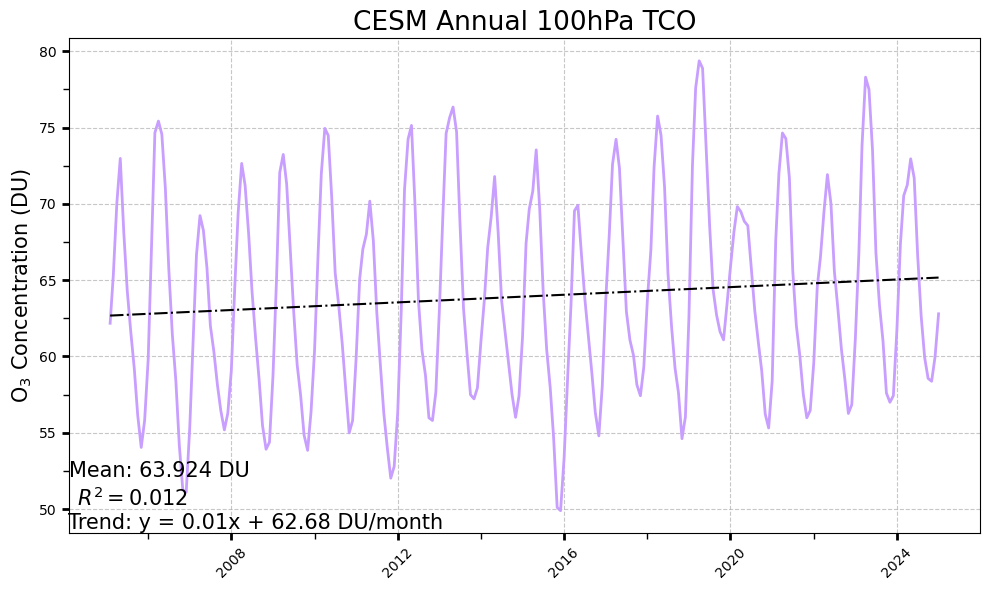

In [9]:
timeseries_plot(cesm_dates, global_cesm_data, cesm_lin_reg, "CESM Annual 100hPa TCO", r_squared_cesm, cesm_slope, cesm_intercept)

In [10]:
global_omi_mls_data = omi_mls_ds.mean(dim={'lat','lon'})
#global_omi_mls_data

In [11]:
omi_mls_dates = omi_mls_ds.coords['yearmonth']
num_omi_mls_dates = np.arange(0, len(omi_mls_dates), 1)

In [12]:
omi_mls_slope, omi_mls_intercept, r_value_omi_mls, p_value, std_err = linregress(num_omi_mls_dates, global_omi_mls_data)
omi_mls_lin_reg = omi_mls_slope * num_omi_mls_dates + omi_mls_intercept
r_squared_omi_mls = r_value_omi_mls**2

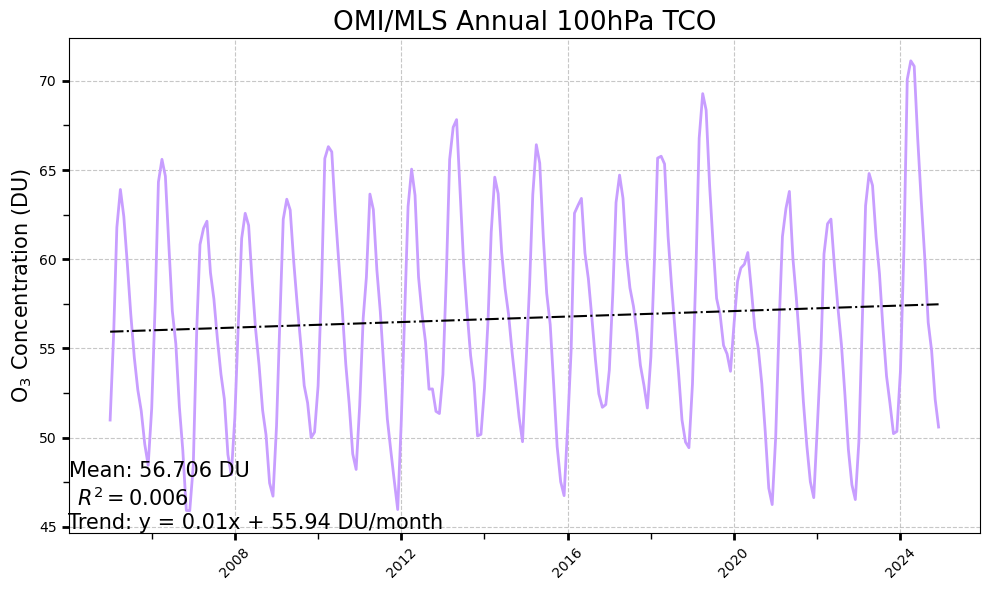

In [13]:
timeseries_plot(omi_mls_dates, global_omi_mls_data, omi_mls_lin_reg, "OMI/MLS Annual 100hPa TCO", r_squared_omi_mls, omi_mls_slope, omi_mls_intercept) #True, "OMIMLS_100"

In [14]:
global_omi_mls_data = global_omi_mls_data.rename({"yearmonth": "time"})
difference = global_cesm_data - global_omi_mls_data

In [15]:
diff_dates = difference.coords['time']
num_diff_dates = np.arange(0, len(diff_dates), 1)

In [16]:
diff_slope, diff_intercept, r_value_diff, p_value, std_err = linregress(num_diff_dates, difference)
diff_lin_reg = diff_slope * num_diff_dates + diff_intercept
r_squared_diff = r_value_diff**2

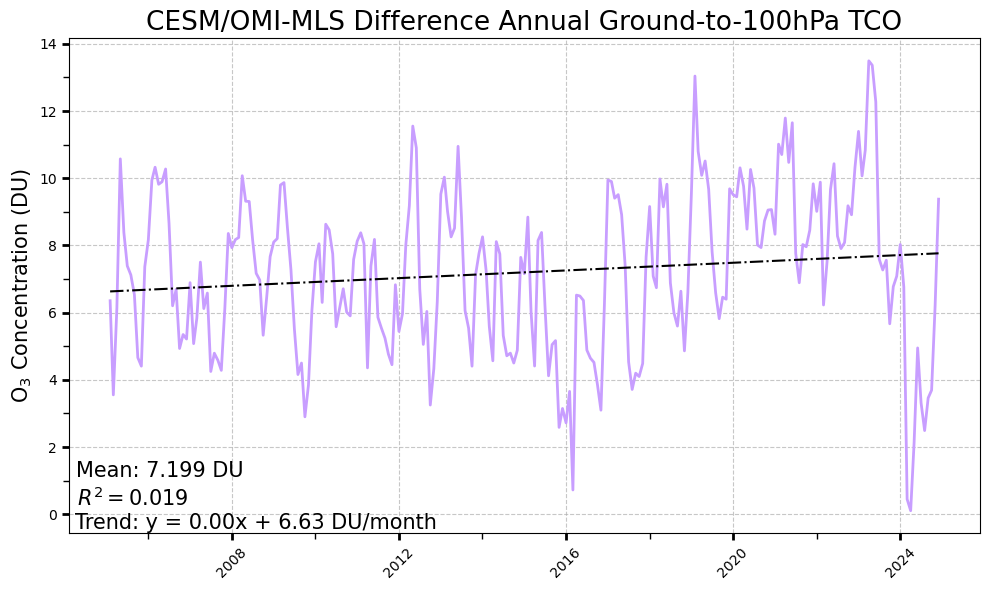

In [17]:
timeseries_plot(diff_dates, difference, diff_lin_reg, "CESM/OMI-MLS Difference Annual Ground-to-100hPa TCO", r_squared_diff, diff_slope, diff_intercept, True, '100') 

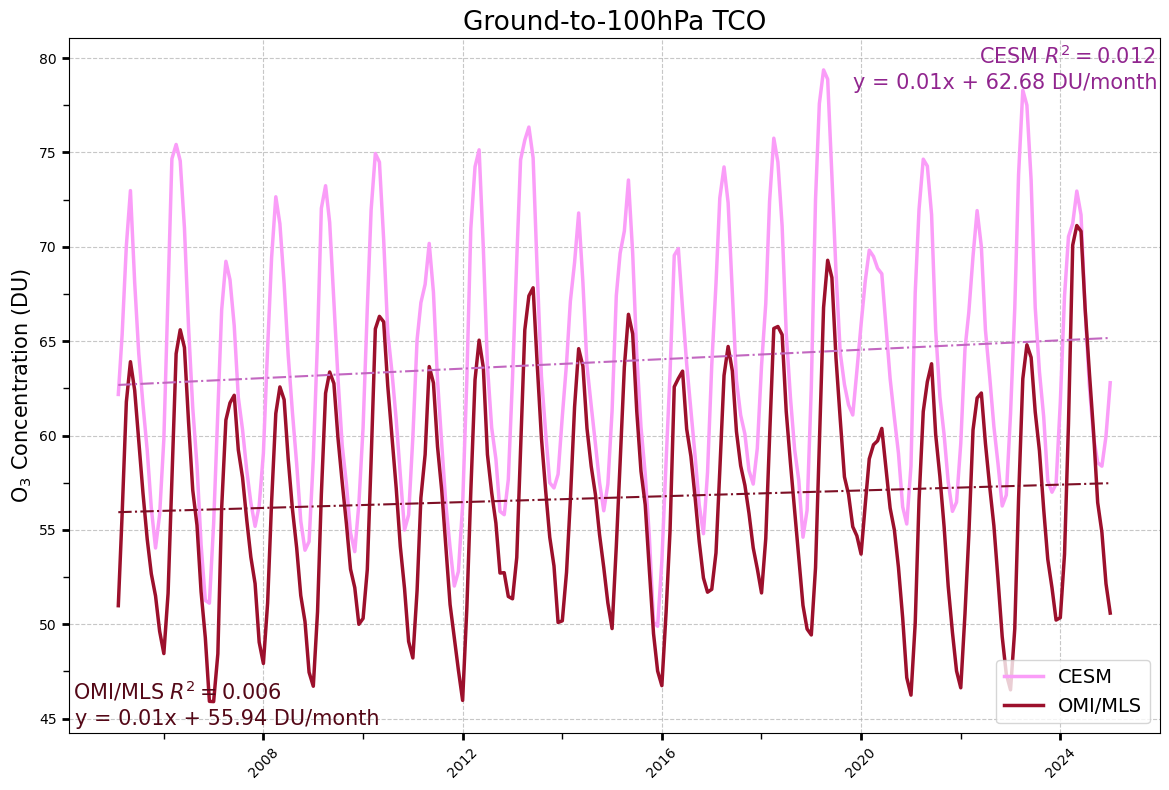

In [18]:
plt.figure(figsize=(12,8))
ax = plt.axes()

plt.plot(cesm_dates, global_cesm_data, linewidth=2.5, color='#fa9df8')
plt.plot(cesm_dates, global_omi_mls_data, linewidth=2.5, color="#9c102c")

plt.plot(cesm_dates, cesm_lin_reg, color='#c267c0', linestyle='dashdot', linewidth=1.5)
plt.plot(cesm_dates, omi_mls_lin_reg, color='#7d0f25', linestyle='dashdot', linewidth=1.5)
#plt.plot(cesm_dates, linreg, color='black', linestyle='dashdot', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.7)

#cesm_mean = f"{cesm_dates.mean().data:.3f}"

ax.text(0.915, 0.975, 'CESM ' + '$R^2=$' + f"{r_squared_cesm:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#91268f')
ax.text(0.858, 0.935, f'y = {cesm_slope:.2f}x + {cesm_intercept:.2f}' + " DU/month", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#91268f')


#omi_mls_mean = f"{cesm_dates.mean().data:.3f}"

ax.text(0.1, 0.06, 'OMI/MLS ' + '$R^2=$' + f"{r_squared_omi_mls:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#540817')
ax.text(0.145, 0.02, f'y = {omi_mls_slope:.2f}x + {omi_mls_intercept:.2f}' + " DU/month", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#540817')


ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='major', width=2)
ax.tick_params(which='minor', width=1)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=4)


plt.legend(['CESM', 'OMI/MLS'], loc='lower right', prop={'size':  14})
           
plt.title("Ground-to-100hPa TCO", fontsize=19)
plt.ylabel("$\mathregular{O_3}$ Concentration (DU)", fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
    
plt.savefig("figures/Annual_Time_Series_100_hPa_BOTH.png")

plt.show()

In [19]:
ax.text(0.055, 0.075, 'CESM ' + '$R^2=$' + f"{r_squared_cesm:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#c267c0')
ax.text(0.145, 0.03, f'y = {cesm_slope:.2f}x + {cesm_intercept:.2f}' + " DU/month", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#c267c0')


#omi_mls_mean = f"{cesm_dates.mean().data:.3f}"

ax.text(0.935, 0.975, 'OMI/MLS ' + '$R^2=$' + f"{r_squared_omi_mls:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#7d0f25')
ax.text(0.85, 0.935, f'y = {omi_mls_slope:.2f}x + {omi_mls_intercept:.2f}' + " DU/month", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15, color='#7d0f25')


Text(0.85, 0.935, 'y = 0.01x + 55.94 DU/month')